# __Project Description__


Dataset: https://archive.ics.uci.edu/ml/datasets/bank+marketing

The goal of the project is to determine will the client subscribe a bank term deposit

## __Referenced papers__
1. https://ieeexplore.ieee.org/abstract/document/9065648
2. https://www.researchgate.net/publication/323198261_Customer_Profiling_using_Classification_Approach_for_Bank_Telemarketing
3. https://ieeexplore.ieee.org/abstract/document/8391441
4. https://ieeexplore.ieee.org/document/9655824

# __Exploratory Data Analysis__

First we read the dataset into dataframe. Notice that the dataset is a csv file but separated by `;`

In [24]:
import pandas as pd

df = pd.read_csv("./dataset/bank-additional/bank-additional.csv",sep=";")

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


Drop column __duration__, according to UCI:    

> ` this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.`

In [25]:
df.drop(columns="duration", inplace=True)


Getting info of dataframe. There is no null data in any of the feature. So we don't need to handle this case

In [26]:
df.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  campaign        4119 non-null   int64  
 11  pdays           4119 non-null   int64  
 12  previous        4119 non-null   int64  
 13  poutcome        4119 non-null   object 
 14  emp.var.rate    4119 non-null   float64
 15  cons.price.idx  4119 non-null   float64
 16  cons.conf.idx   4119 non-null   float64
 17  euribor3m       4119 non-null   f

### __Visualization__

Visualizing distribution of categorical features and label using pie chart. As can be seen, we have a fairly imbalanced data


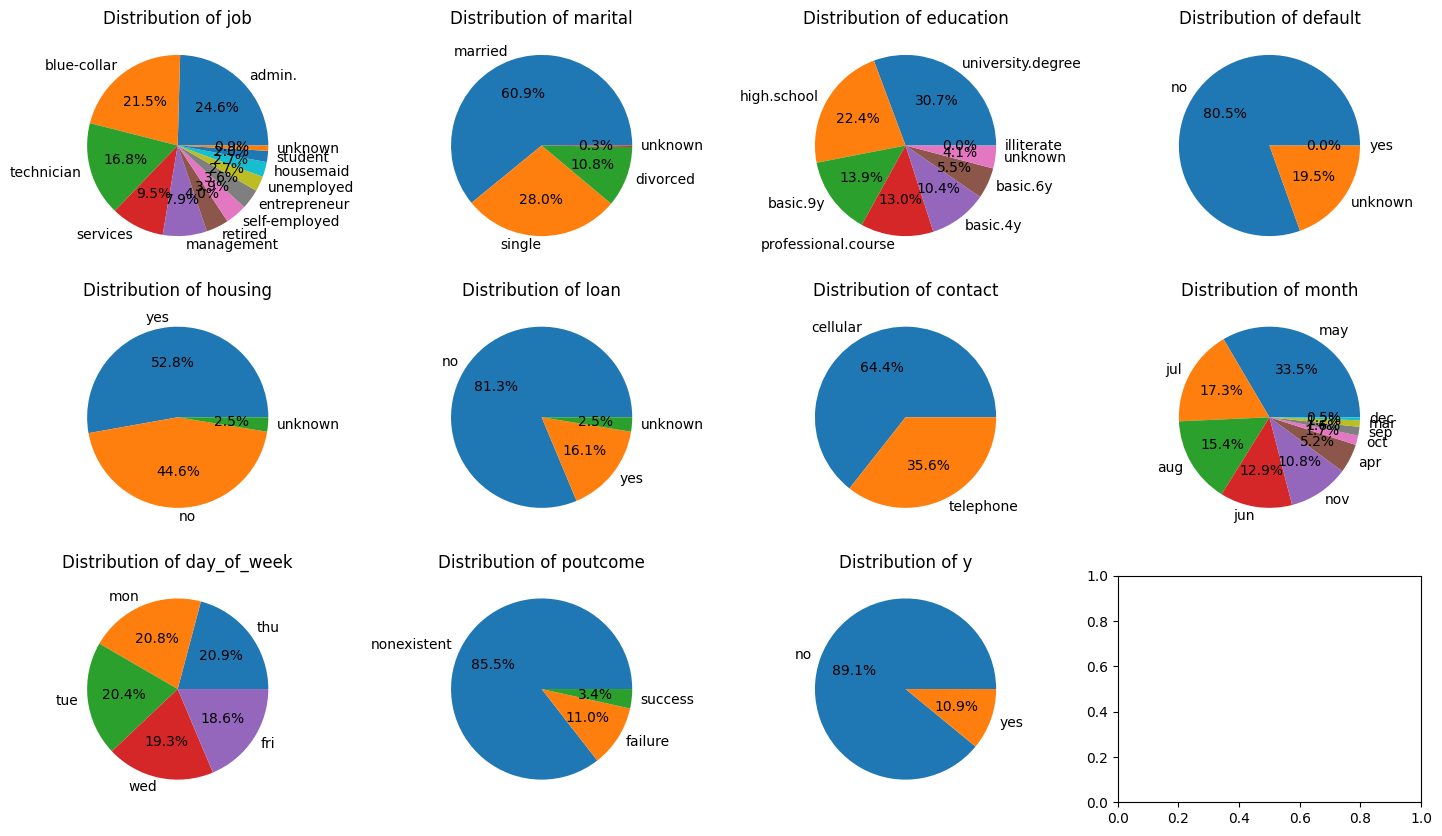

In [27]:
import matplotlib.pyplot as plt

pie_visualization = ["job", "marital", "education",
                     "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome",  "y"]

fig, axes = plt.subplots(3, 4, figsize=(18, 10))

for i, feature in enumerate(pie_visualization):
    category = df[feature].value_counts()
    axes.flat[i].set_title("Distribution of {}".format(feature))
    axes.flat[i].pie(category, labels=category.index, autopct='%1.1f%%')


Visualizing when the data is normally collected. As can be seen, most of the data is collected around May. The day_of_week is fairly balanced

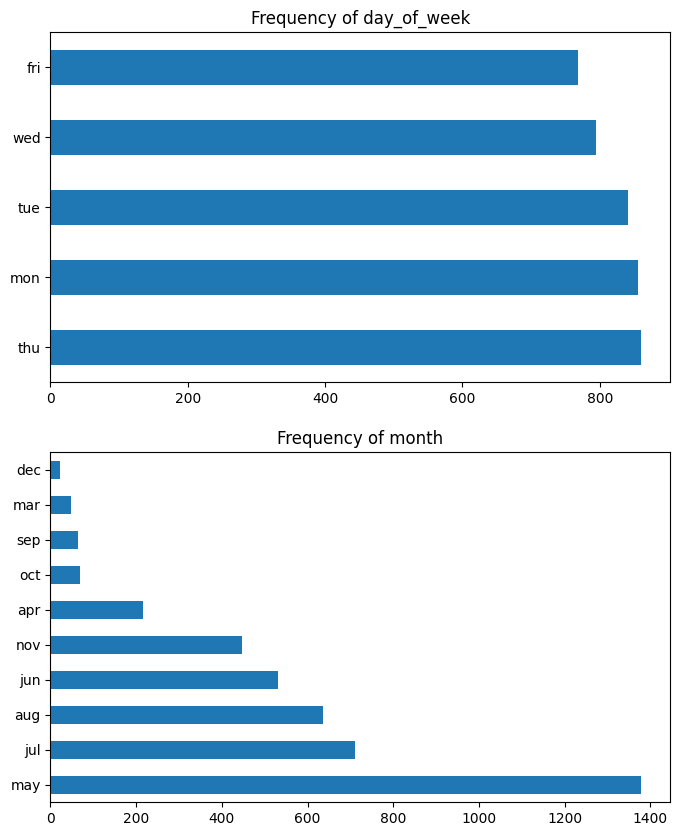

In [28]:
bar_visualization = ["day_of_week", "month"]
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
for i, ax in enumerate(axes.flat, start=0):
    feature = bar_visualization[i]
    df[feature].value_counts().plot(kind="barh", ax=ax,title="Frequency of {}".format(feature))


Visualizing correlation between numeric features    

As can be noticed from the graph, `emp.var.rate`, `nr.employed`, `euribor3m`,`cons.price.index` are highly correlated
Depending on the algorithm, we may need remove one of the above listed features. This is a **Multicollinearity** problem 

<class 'pandas.core.frame.DataFrame'>


<AxesSubplot: >

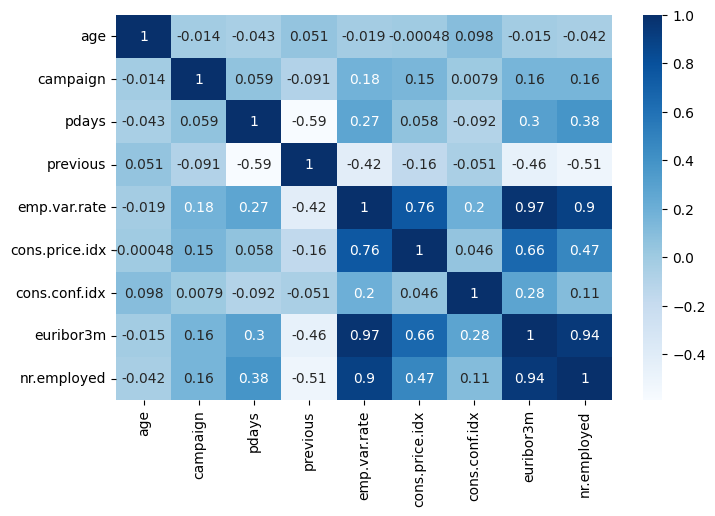

In [29]:
import seaborn as sb
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8, 5
numerical_features = ["age", "campaign", "pdays", "previous", "emp.var.rate",
                      "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

corr = df[numerical_features].corr()
print(type(corr))
sb.heatmap(corr, cmap="Blues", annot=True)


For numerical features, we are also interested in their distributions. 

As can be seen, there are lots of outliers in age, campaign, pdays, previous

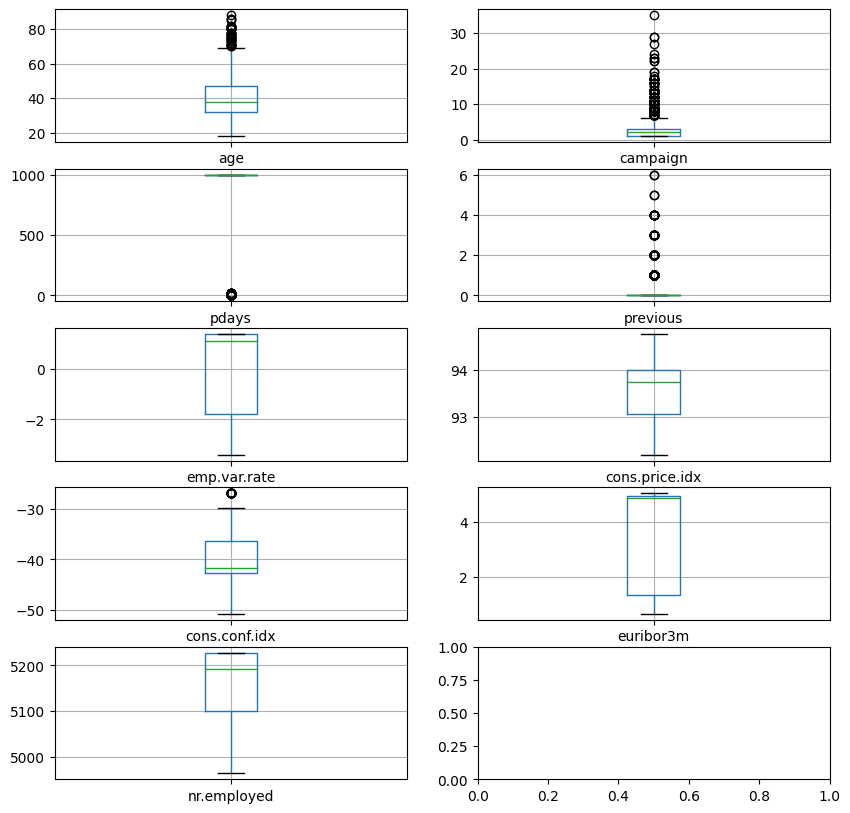

In [30]:
from math import ceil


fig, axes = plt.subplots(ceil(len(numerical_features)/2),2, figsize=(10, 10))

for i, feature in enumerate(numerical_features):
    df.boxplot(column=feature, ax=axes.flat[i])


For features with many outliers, count frequency

We notice that, people between 25 and 60 years old will likely to invest.

For `campaign`, there are many who gets contacted by bank representative by the first time, the same can be said for `pdays` and `previous`.

Potentially, we need to remove outliers from the 4 mentioned features

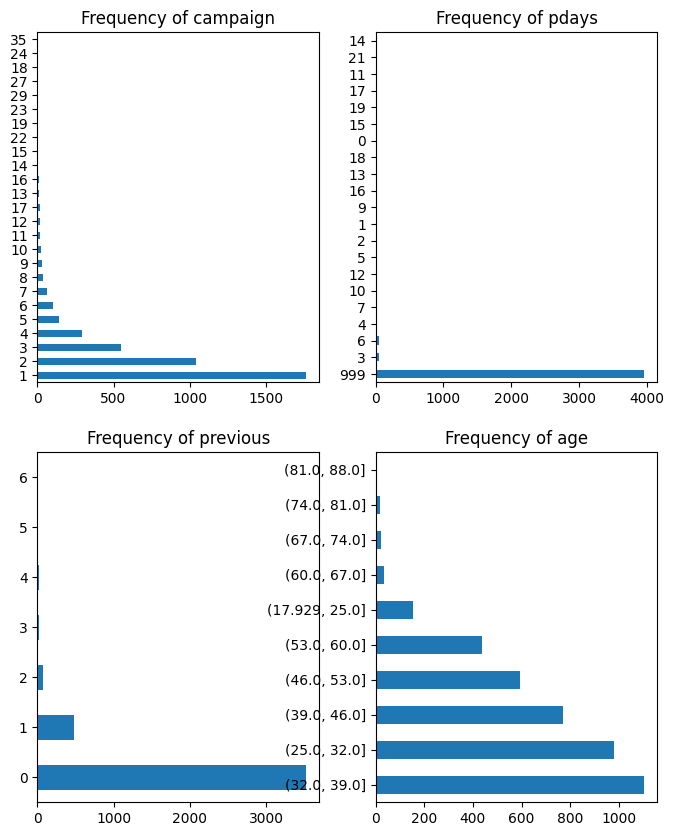

In [31]:
feature_outliers = ["campaign", "pdays", "previous"]
fig, axes = plt.subplots(2, 2, figsize=(8, 10))

df["age"].value_counts(bins=10).plot(kind="barh", title="Frequency of age")

for i, feature in enumerate(feature_outliers):
    df[feature].value_counts().plot(
        kind="barh", ax=axes.flat[i], title="Frequency of {}".format(feature))


### __Prepare data for ML algorithms__

Some ML algorithms do not work well with categorical data, therefore, we need to convert those categorical data to number.

There are several features that are strictly __nominal__, perform **One Hot Encoder** on these features. Some features are __ordinal__, with these features, we perform **Ordinal Encoder**.

In [32]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Ordering array from low to high
# The first element has lowest priority, the last element has highest priority
# This ranking is important!!
education = ["illiterate", "basic.4y", "basic.6y", "basic.9y",
             "unknown", "high.school", "professional.course", "university.degree"]

credit_default = ["yes", "unknown", "no"]

poutcome = ["failure", "nonexistent", "success"]

# 0 means no, 1 means yes
y = ["no", "yes"]

columnTransformer = ColumnTransformer(
    [
        ("OneHotEncoder", OneHotEncoder(), [
         "job", "marital", "contact", "housing", "loan", "day_of_week", "month"]),
        ("OrdinalEncoder", OrdinalEncoder(
            categories=[education, credit_default, poutcome, y]),
            ["education", "default", "poutcome", "y"]),
    ],
    remainder="passthrough"
)

transformed_df = pd.DataFrame(
    columnTransformer.fit_transform(df),
    columns=columnTransformer.get_feature_names_out()
)

# Need to find out a way to feature engineering day and month
# Cannot use label encoding these data are cyclical data in nature
# Refer https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
# Also, should housing and loan be in encoded using OrdinalEncoder or OneHotEncoder?
# I feel like there is no direct ranking between them so to play it safe, I use OneHotEncoder for it

transformed_df.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Columns: 52 entries, OneHotEncoder__job_admin. to remainder__nr.employed
dtypes: float64(52)
memory usage: 1.6 MB


After running the encoder, we notice that the `dtypes` of dataframe is `float64` for all features!
Now we separate features and label

In [33]:
x = transformed_df.drop(columns=["OrdinalEncoder__y"])
y = transformed_df["OrdinalEncoder__y"]

print(x.info(verbose=False))
print(y.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Columns: 51 entries, OneHotEncoder__job_admin. to remainder__nr.employed
dtypes: float64(51)
memory usage: 1.6 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 4119 entries, 0 to 4118
dtypes: float64(1)
memory usage: 32.3 KB
None


# Algorithms

## Paper 2

Link: https://www.researchgate.net/publication/323198261_Customer_Profiling_using_Classification_Approach_for_Bank_Telemarketing

Using C4.5 algorithm to predict if a client will subscribe a term deposit.  

In theory, decision tree should be able to work with categorical data. However, the current implementation of   
decision tree in scikit-learn 1.1 does not handle categorical data. Refer https://scikit-learn.org/1.1/modules/tree.html    

As a result, we need to use OneHotEncoder and Ordinal Encoder on the features. `transformed_df` variable is a dataframe that
has all features encoded.

There are trades off of doing this, notably higher tree depth and the time it takes for the algorithm to finish is longer...

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn import tree

%matplotlib inline


def report_result(y_pred, y_true, clf):
    cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues")
    print(classification_report(y_true, y_pred))


def tree_visualizer(tree_classifier, feature_names):
    fig = plt.figure(figsize=(25, 20))
    _ = tree.plot_tree(tree_classifier,
                       feature_names=feature_names,
                       class_names=['No', "Yes"],
                       filled=True)


              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       748
         1.0       0.44      0.26      0.33        76

    accuracy                           0.90       824
   macro avg       0.69      0.61      0.64       824
weighted avg       0.88      0.90      0.89       824



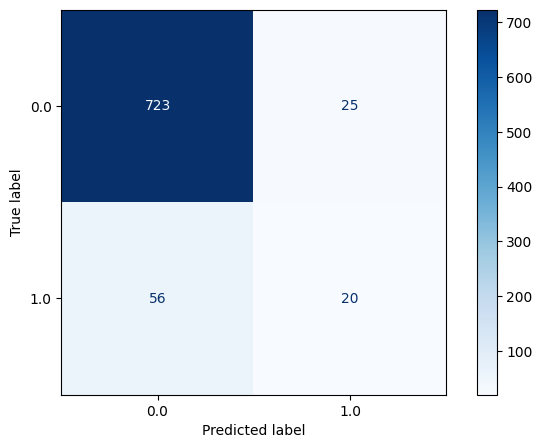

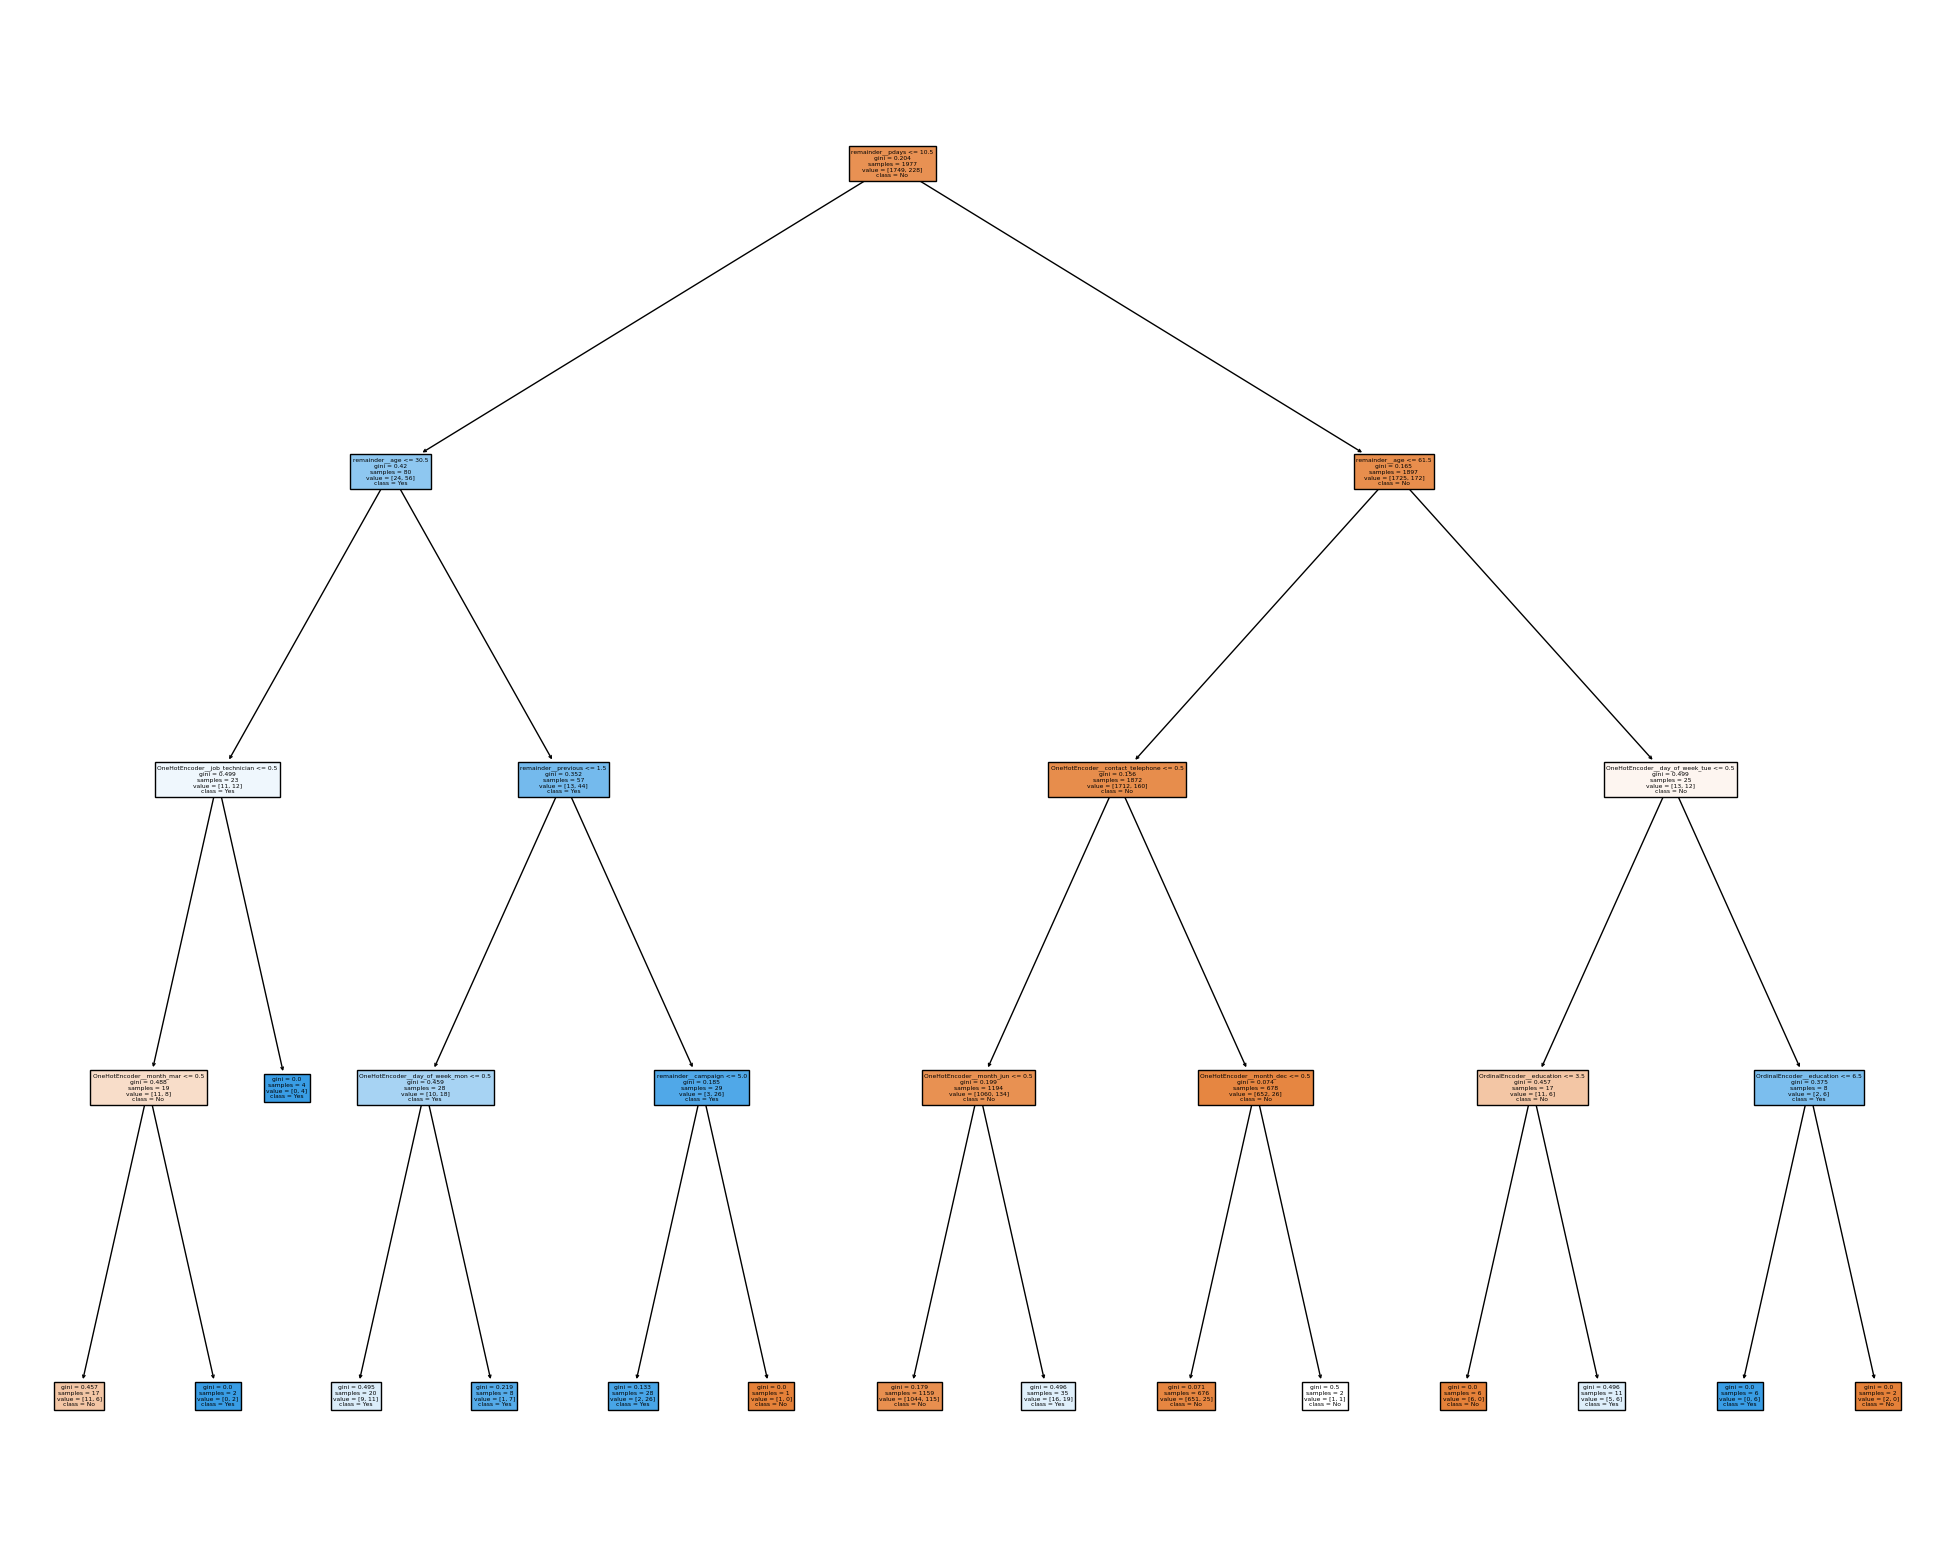

In [35]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

# The following features are not used by the paper, therefore, we're not going to use these features as well
tree_dataset_x = x.drop(columns=["remainder__euribor3m", "remainder__nr.employed",
                                 "remainder__cons.price.idx", "remainder__emp.var.rate", "remainder__cons.conf.idx"], inplace=False)

# Seperate into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    tree_dataset_x, y, train_size=0.8, test_size=0.2, random_state=0)

# Create validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
    x_train, y_train, train_size=0.6, test_size=0.4, random_state=0)


tree_clf = DecisionTreeClassifier(max_depth=4)

tree_clf.fit(X_train, Y_train)
y_pred = tree_clf.predict(x_test)
report_result(y_pred, y_test, tree_clf)
tree_visualizer(tree_clf, X_train.columns)


Hyper parameter tuning with decision tree

We do not need to scale data in order to use decision tree, thus it will be skipped.

The scoring criteria here will be `balanced_accuracy`, this is to account for our imbalanced dataset

In [36]:
from sklearn.pipeline import Pipeline

dec_tree = DecisionTreeClassifier(random_state=0)
pipe = Pipeline(steps=[
    ('dec_tree', dec_tree)])

parameters = dict(
    dec_tree__class_weight=["balanced"],
    dec_tree__criterion=['gini', 'entropy'],
    dec_tree__max_depth=[2, 4, 6, 8, 10],
    dec_tree__splitter=["best", "random"],
    dec_tree__max_features=["sqrt", "log2", None]
)

tree_tuning = GridSearchCV(pipe, parameters, scoring=[
                           "accuracy", "recall", "balanced_accuracy"], refit="accuracy")
tree_tuning.fit(X_valid, Y_valid)
print("Best params", tree_tuning.best_params_)


Best params {'dec_tree__class_weight': 'balanced', 'dec_tree__criterion': 'entropy', 'dec_tree__max_depth': 2, 'dec_tree__max_features': 'log2', 'dec_tree__splitter': 'best'}


Using tuned parameters on the test dataset

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       748
         1.0       0.67      0.08      0.14        76

    accuracy                           0.91       824
   macro avg       0.79      0.54      0.55       824
weighted avg       0.89      0.91      0.88       824



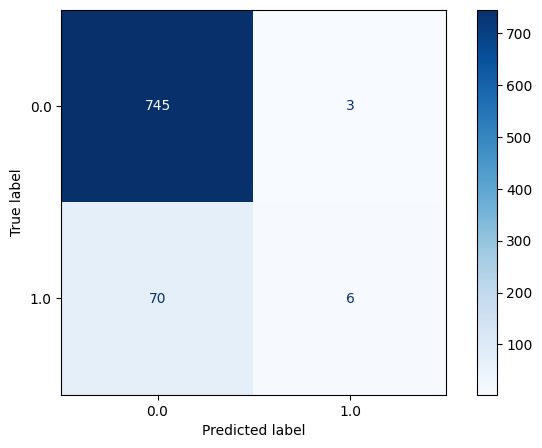

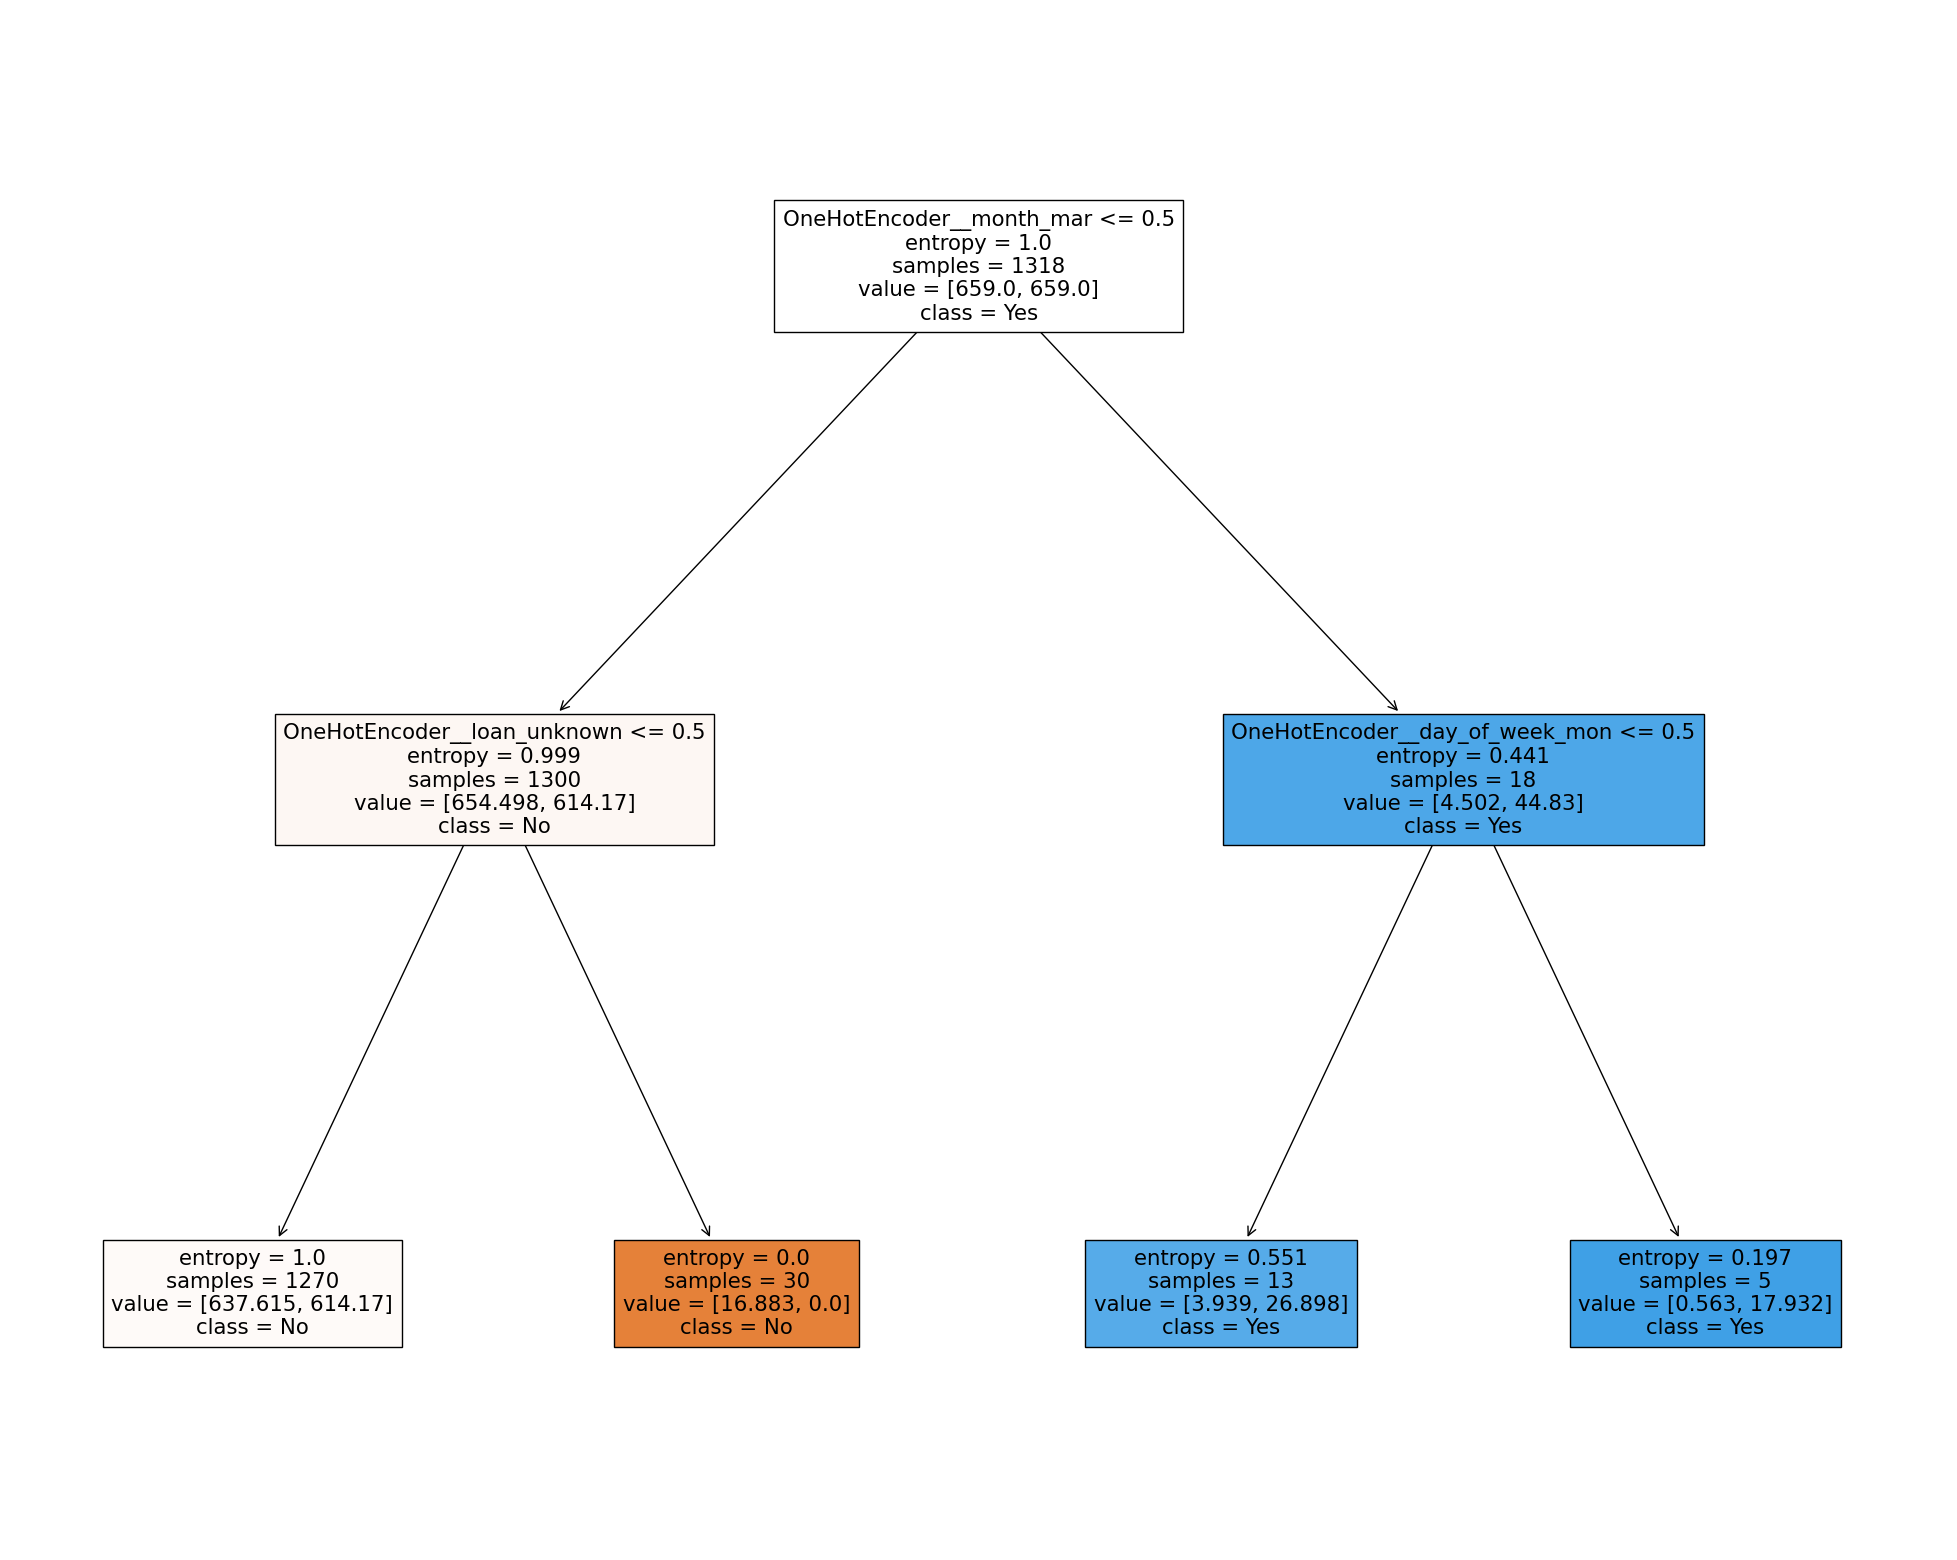

In [37]:
report_result(tree_tuning.predict(x_test), y_test, tree_tuning)
tree_visualizer(tree_tuning.best_estimator_.get_params()['dec_tree'], x_test.columns)

The paper result mentioned that on testing data, they achivieved `90.09%`, `59.06%`, `93.23%` on accuracy score, specificity, and sensitivity respectively. 

As for our result, we achieved `91%` on accuracy score, `67%` on specitivity score and finally `91%` on sensitivity score.

Compared to the paper result, we found out that we are better at overall accuracy of the algorithm as well as correctly identifying term deposit subscriber.

However, there are a lot of room for improvement with the algorithm, for example, the recall rate of term deposit subscriber is only at `8%` only. Meaning, we are missing out on a lot of other potential customers.

Paper 3: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9765152


This Paper found that using the RandomForest model it had an accuracy of `94.02%`, precision of `90.41%`, recall of `98.49%`, and a F-measure of `94.28%`.

In [48]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)

rfc.fit(x,y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
y_true = rfc.predict(X_test)
print(classification_report(y_true, y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1123
         1.0       0.90      0.99      0.94       113

    accuracy                           0.99      1236
   macro avg       0.95      0.99      0.97      1236
weighted avg       0.99      0.99      0.99      1236



Using our own model we found that the accuracy will jump up to `99%` with our preprocessing and feature selection.
The recall score for this model is `99%` and the f1-score is `94%`. Although the f1-score for our model is slightly less than the paper's the recall score and the accuracy jumped by such a considerable margin it can be said that this was a severe improvement to the paper.